In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/BigData/midterm/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BigData/midterm


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -v https://dlcdn.apache.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz

--2022-12-01 20:15:53--  https://dlcdn.apache.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-01 20:15:53 ERROR 404: Not Found.



In [4]:
!tar -xvf spark-3.2.2-bin-hadoop3.2.tgz

spark-3.2.2-bin-hadoop3.2/
spark-3.2.2-bin-hadoop3.2/conf/
spark-3.2.2-bin-hadoop3.2/conf/fairscheduler.xml.template
spark-3.2.2-bin-hadoop3.2/conf/log4j.properties.template
spark-3.2.2-bin-hadoop3.2/conf/metrics.properties.template
spark-3.2.2-bin-hadoop3.2/conf/spark-defaults.conf.template
spark-3.2.2-bin-hadoop3.2/conf/spark-env.sh.template
spark-3.2.2-bin-hadoop3.2/conf/workers.template
spark-3.2.2-bin-hadoop3.2/bin/
spark-3.2.2-bin-hadoop3.2/bin/beeline
spark-3.2.2-bin-hadoop3.2/bin/beeline.cmd
spark-3.2.2-bin-hadoop3.2/bin/docker-image-tool.sh
spark-3.2.2-bin-hadoop3.2/bin/find-spark-home
spark-3.2.2-bin-hadoop3.2/bin/find-spark-home.cmd
spark-3.2.2-bin-hadoop3.2/bin/load-spark-env.cmd
spark-3.2.2-bin-hadoop3.2/bin/load-spark-env.sh
spark-3.2.2-bin-hadoop3.2/bin/pyspark
spark-3.2.2-bin-hadoop3.2/bin/pyspark.cmd
spark-3.2.2-bin-hadoop3.2/bin/pyspark2.cmd
spark-3.2.2-bin-hadoop3.2/bin/run-example
spark-3.2.2-bin-hadoop3.2/bin/run-example.cmd
spark-3.2.2-bin-hadoop3.2/bin/spark-clas

In [5]:
# Install the python library findspark to locate Spark.
!pip install -q findspark

# Specify environmental parameters
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/BigData/midterm/spark-3.2.2-bin-hadoop3.2" 

In [6]:
# Creating local Spark session 
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
# Importing libraries we will need
import pandas as pd
import pyspark
import csv
import math
import matplotlib.pyplot as mp
import seaborn as sb
import numpy as np
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as f
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType,BooleanType,DateType, DoubleType, BooleanType
from pyspark.sql.functions import col, unix_timestamp, to_date, trim, lower, concat, lit, isnan, when

# Data Loading

In [8]:
# CSV file loading into a Spark dataframe
dataframe = spark.read.csv('/content/drive/MyDrive/BigData/midterm/train.csv', header = True, multiLine=True, sep=',',quote="\"",escape="\"")
dataframe.show()
type(dataframe)

+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-----------+------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+--------+----+
|      id|  log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|   latitude|   longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+--

pyspark.sql.dataframe.DataFrame

# Data Preprocessing

In [9]:
# Cleaning Amenities field of unnnecessary characters
dataframe = dataframe.withColumn("amenities", regexp_replace("amenities", "[^0-9a-zA-Z_,\-\s]+", ""))

In [10]:
# Relacing f and t in the dataset with their whole values of True and False
cols = ["host_has_profile_pic","host_identity_verified","instant_bookable"]
for col in cols:
    dataframe = dataframe.withColumn(col, 
     f.when(f.col(col) == 'f', 'False')
      .when(f.col(col) == 't', 'True')
      .otherwise(f.col(col)))

In [11]:
# Handling Null values

# Fill NA values in review_scores_rating with its mean value (The default imputation strategy)
dataframe = dataframe.withColumn("review_scores_rating",dataframe.review_scores_rating.cast(IntegerType()))
imputer = Imputer(
    inputCols=["review_scores_rating"], 
    outputCols=["review_scores_rating"]
)
dataframe = imputer.fit(dataframe).transform(dataframe)

# Filling Na values with general values for bathrooms, bedrooms, etc beds columns
# Removing % sign from host_response_rate and space in amenities with underscore

dataframe = dataframe.na.fill({'bathrooms': '0', 'bedrooms': '0','beds':'1', 'host_response_rate':'0', 
                               'host_has_profile_pic': 'False' , 'host_identity_verified':'False',
                               'instant_bookable':'False'}).withColumn("host_response_rate", f.regexp_replace(f.col("host_response_rate"), "[%]", "")).withColumn("amenities", f.regexp_replace(f.col("amenities"), "[ ]", "_"))
dataframe.show()
type(dataframe)

+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-----------+------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+--------+----+
|      id|  log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|   latitude|   longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+--

pyspark.sql.dataframe.DataFrame

In [12]:
# Replace null values in date columns by their median

# Performing median replacement for first_review
first_review = dataframe.select("first_review").na.drop(subset=["first_review"]) # Droping all null values
first_review.orderBy('first_review') #Arranging them in order by ascending order
fVal=math.floor((first_review.count()-1)/2)
first_reviewMedian = first_review.collect()[fVal].first_review
dataframe = dataframe.na.fill({'first_review': first_reviewMedian})

# Performing median replacement for last_review
last_review = dataframe.select("last_review").na.drop(subset=["last_review"]) # Droping all null values
last_review.orderBy('last_review') #Arranging them in order by ascending order
fVal=math.floor((last_review.count()-1)/2)
last_reviewMedian = last_review.collect()[fVal].last_review
dataframe = dataframe.na.fill({'last_review': last_reviewMedian})

# Droping rows for which host_since date doesnt exist
dataframe = dataframe.na.drop(subset=["host_since"])

# Convert first_review, last_review, host_since to datetime
dataframe = dataframe.withColumn("first_review",f.to_timestamp(f.col("first_review"),"M/d/y").cast(DateType()))
dataframe = dataframe.withColumn("last_review",f.to_timestamp(f.col("last_review"),"M/d/y").cast(DateType()))
dataframe = dataframe.withColumn("host_since",f.to_timestamp(f.col("host_since"),"M/d/y").cast(DateType()))

dataframe.show()
type(dataframe)

+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-----------+------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+--------+----+
|      id|  log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|   latitude|   longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|bedrooms|beds|
+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+--

pyspark.sql.dataframe.DataFrame

In [13]:
# Get date number of dates from all the date fields (Difference between minimum of the column to the value of the column)
# This helps in easy processing for date type objects as they are converted into a numeric value

dataframe = dataframe.withColumn("first_review_days",
        f.datediff(
            f.col("first_review"),
            f.lit(dataframe.agg(f.min(dataframe["first_review"])).collect()[0][0])
        )
    )

dataframe = dataframe.withColumn("last_review_days",
        f.datediff(
            f.col("last_review"),
            f.lit(dataframe.agg(f.min(dataframe["last_review"])).collect()[0][0])
        )
    )

dataframe = dataframe.withColumn("host_since_days",
        f.datediff(
            f.col("host_since"),
            f.lit(dataframe.agg(f.min(dataframe["host_since"])).collect()[0][0])
        )
    )

#Dont do .show in the same field else it converts to nonetype
#Adding Price field convert later to decimal value
dataframe = dataframe.withColumn("Price",round(f.exp(f.col("log_price")), 2))
type(dataframe)

pyspark.sql.dataframe.DataFrame

In [14]:
# Confining fields to a datatype (Proper formating)

dataframe = dataframe.withColumn("accommodates", f.col("accommodates").cast(IntegerType()))
dataframe = dataframe.withColumn("bathrooms", f.col("bathrooms").cast(DoubleType())) # changed from integer to double
dataframe = dataframe.withColumn("zipcode", f.col("zipcode").cast(IntegerType()))
dataframe = dataframe.withColumn("latitude", f.col("latitude").cast(DoubleType()))
dataframe = dataframe.withColumn("log_price", f.col("log_price").cast(DoubleType()))
dataframe = dataframe.withColumn("longitude", f.col("longitude").cast(DoubleType()))
dataframe = dataframe.withColumn("number_of_reviews", f.col("number_of_reviews").cast(IntegerType()))
dataframe = dataframe.withColumn("review_scores_rating", f.col("review_scores_rating").cast(IntegerType()))
dataframe = dataframe.withColumn("bedrooms", f.col("bedrooms").cast(IntegerType()))
dataframe = dataframe.withColumn("beds", f.col("beds").cast(IntegerType()))
dataframe = dataframe.withColumn("cleaning_fee", f.col("cleaning_fee").cast(BooleanType())) 
dataframe = dataframe.withColumn("host_has_profile_pic", f.col("host_has_profile_pic").cast(BooleanType())) 
dataframe = dataframe.withColumn("host_identity_verified", f.col("host_identity_verified").cast(BooleanType()))
dataframe = dataframe.withColumn("id", f.col("id").cast(IntegerType()))
dataframe = dataframe.withColumn("host_response_rate", f.col("host_response_rate").cast(IntegerType()))
dataframe = dataframe.withColumn("instant_bookable", f.col("instant_bookable").cast(BooleanType()))
dataframe = dataframe.withColumn("review_scores_rating", f.col("review_scores_rating").cast(DoubleType()))
dataframe = dataframe.withColumn("bedrooms", f.col("bedrooms").cast(DoubleType()))
dataframe = dataframe.withColumn("beds", f.col("beds").cast(DoubleType()))

In [15]:
# Finding correlation between numeric fields of the data
dataframe.toPandas().corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-15-6565de899b78>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  dataframe.toPandas().corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,id,log_price,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,first_review_days,last_review_days,host_since_days,Price
id,1.00,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.01,-0.01,-0.00,-0.00,0.00,-0.00
log_price,-0.01,1.00,0.57,0.35,0.11,-0.01,0.02,-0.04,-0.04,-0.00,-0.05,-0.03,0.07,0.03,0.47,0.44,-0.05,-0.01,-0.08,0.84
accommodates,-0.01,0.57,1.00,0.50,0.18,-0.00,0.06,0.14,0.05,-0.08,-0.08,0.04,-0.01,0.10,0.71,0.81,-0.01,0.04,0.01,0.52
bathrooms,-0.00,0.35,0.50,1.00,0.06,-0.00,0.02,0.05,0.00,-0.14,-0.13,-0.04,0.01,0.14,0.59,0.52,0.01,-0.02,0.01,0.46
cleaning_fee,-0.00,0.11,0.18,0.06,1.00,0.02,0.16,0.26,0.01,-0.06,-0.07,0.11,0.03,0.07,0.11,0.13,-0.07,0.07,-0.09,0.03
host_has_profile_pic,-0.00,-0.01,-0.00,-0.00,0.02,1.00,0.08,0.03,-0.01,0.00,-0.00,0.02,0.00,0.00,0.00,-0.00,-0.02,-0.00,-0.03,-0.02
host_identity_verified,-0.00,0.02,0.06,0.02,0.16,0.08,1.00,0.12,-0.09,-0.04,-0.06,0.16,0.05,0.07,0.03,0.04,-0.19,-0.05,-0.33,-0.01
host_response_rate,-0.00,-0.04,0.14,0.05,0.26,0.03,0.12,1.00,0.14,-0.07,-0.08,0.28,0.05,0.09,0.06,0.12,-0.03,0.39,0.00,-0.06
instant_bookable,0.00,-0.04,0.05,0.00,0.01,-0.01,-0.09,0.14,1.00,-0.01,-0.00,0.08,-0.06,0.00,-0.00,0.05,0.17,0.17,0.19,-0.03
latitude,-0.00,-0.00,-0.08,-0.14,-0.06,0.00,-0.04,-0.07,-0.01,1.00,0.90,-0.02,-0.03,-0.87,-0.06,-0.08,0.05,0.16,-0.01,-0.03


# Diving deep into Amenities column

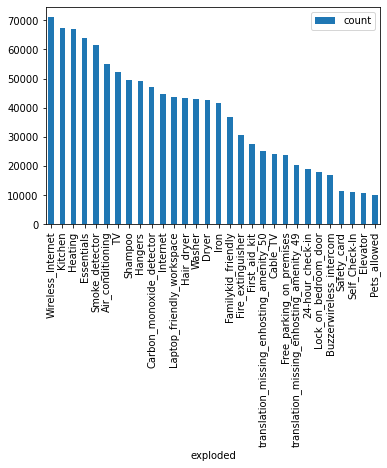

In [16]:
# BReaking down the column to get the total amount of times one amenity was used

amenities = dataframe.select(f.split(f.col("amenities"),",").alias("trial"))

listData = amenities.select(f.explode('trial').alias('exploded')).groupby('exploded').count()

listData = listData.orderBy(f.col("count").desc())
listData.toPandas()[:30].plot.bar(x='exploded')

Most popular amenity is wireless internet followed by kitchen, heating, smoke detecor, Ac and TV

In [17]:
# Viewing the exploded data list with its count
listData.show()

+--------------------+-----+
|            exploded|count|
+--------------------+-----+
|   Wireless_Internet|71086|
|             Kitchen|67354|
|             Heating|66899|
|          Essentials|63851|
|      Smoke_detector|61585|
|    Air_conditioning|55062|
|                  TV|52336|
|             Shampoo|49361|
|             Hangers|49064|
|Carbon_monoxide_d...|47092|
|            Internet|44529|
|Laptop_friendly_w...|43607|
|          Hair_dryer|43245|
|              Washer|43098|
|               Dryer|42643|
|                Iron|41589|
|  Familykid_friendly|36953|
|   Fire_extinguisher|30670|
|       First_aid_kit|27479|
|translation_missi...|25223|
+--------------------+-----+
only showing top 20 rows



In [18]:
# Getting the list of all unique amenities 
listDataNew = listData.select('exploded').rdd.flatMap(lambda x: x).collect()

# Removing unwanted values
listDataNew.remove('')
listDataNew.remove('translation_missing_enhosting_amenity_50')
listDataNew.remove('translation_missing_enhosting_amenity_49')

# Creating a 2D matrix translating presence of amenities for a particular property 
amenitiesDF = dataframe.select(f.col("id"),f.col("amenities"),f.col("log_price"))
for amenity in listDataNew:
    amenitiesDF = amenitiesDF.withColumn(amenity, #["Kitchen","Hot water kettle"]
      f.when(f.col("amenities").contains(amenity),True).otherwise(False))
    amenitiesDF = amenitiesDF.withColumn(amenity,f.col(amenity).cast(BooleanType()))

amenitiesDF.show()

+--------+--------------------+-----------+-----------------+-------+-------+----------+--------------+----------------+-----+-------+-------+------------------------+--------+-------------------------+----------+------+-----+-----+------------------+-----------------+-------------+--------+------------------------+----------------+--------------------+-----------------------+-----------+-------------+--------+------------+--------------------------+----------------+---------+-----+----------------+--------------------+-------+-----+-------+-----+---------------------+-------+------------+-------------------+---------+---------------------+----------+-----+--------------+-----+---------+-------+---------------+-----+------------+--------------------------+------+-------------------+----------+----------------+-----------------------+-----------------------+---------------------+----------------+---------------+------------------+------------------------+----------------------+---------

In [19]:
# Finding correlation of the amenities with each other and log price
amenitiesDF.toPandas().corr().style.background_gradient(cmap='coolwarm').set_precision(2) 
# ......................Refine it for the columns which has greater than 0.1 and then add snapshot

/content/drive/MyDrive/BigData/midterm/spark-3.2.2-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
<ipython-input-19-1d7f0b58234d>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  amenitiesDF.toPandas().corr().style.background_gradient(cmap='coolwarm').set_precision(2)


In [20]:
# Manually selecting only the amenities which has correlation with log price greater than 0.1 
# This is done based on the importance and effect of the particular amenity on the dependant variable

amenitiesDF = amenitiesDF.select('id','Kitchen','Heating','TV','Hair_dryer','Washer','Dryer','Iron','Familykid_friendly','Cable_TV','24-hour_check-in','Elevator','Pets_live_on_this_property','Indoor_fireplace','Gym','Private_entrance','Doorman','Suitable_for_events')

In [21]:
# Joining the amenities 2D matrix with the data we have based on the common column id
fin_dataframe=dataframe.join(amenitiesDF, ["id"], "left")

fin_dataframe.show()

+--------+-----------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-----------+------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+--------+----+-----------------+----------------+---------------+-----+-------+-------+-----+----------+------+-----+-----+------------------+--------+----------------+--------+--------------------------+----------------+-----+----------------+-------+-------------------+
|      id|  log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|   latitude|   longitude|    

# Data Analysis

#### City and Price distribution

In [22]:
# Collecting distint cities
fin_dataframe.select('city').distinct().collect()

[Row(city='LA'),
 Row(city='DC'),
 Row(city='Chicago'),
 Row(city='SF'),
 Row(city='Boston'),
 Row(city='NYC')]

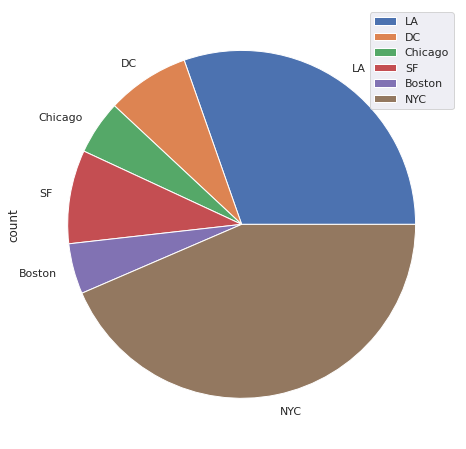

In [23]:
# Plotting the distribution of cities
fin_dataframe.select('city').distinct().collect()
sb.set(rc = {'figure.figsize':(15,8)})
fin_dataframe.groupBy('city').count().toPandas().set_index('city').plot(kind='pie', y='count')


This plot tells us that most of the properties listing we are looking at belongs to New York City or Los Angeles

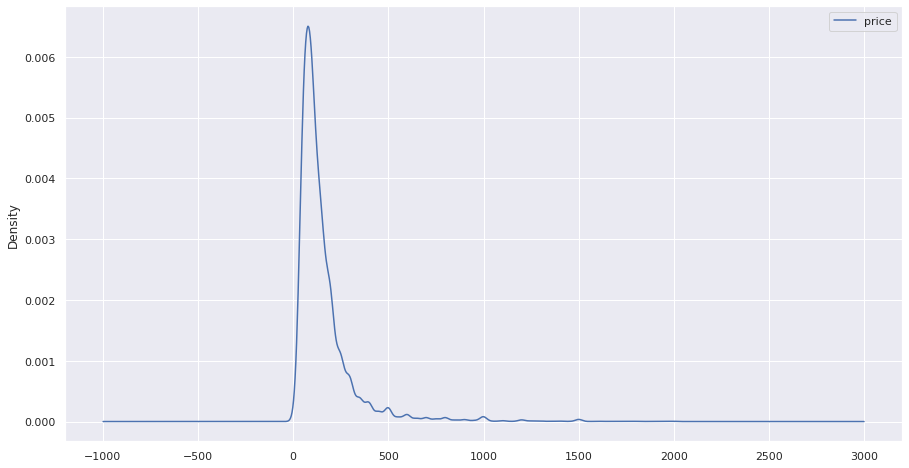

In [24]:
# Looking at the overall distribution of price on a density Graph
fin_dataframe.select('price').toPandas().plot(kind='density')

The density plot basically tells us that the normal rating price range for a 1 night booking of an airbnb property falls under $0 - $500

city
Boston     [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
Chicago    [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
DC         [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
LA         [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
NYC        [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
SF         [[AxesSubplot(0.125,0.657941;0.352273x0.222059...
dtype: object

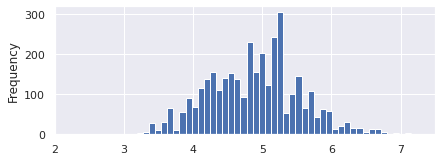

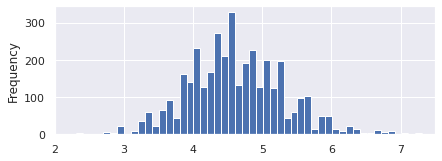

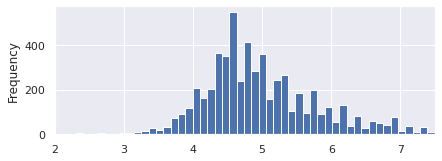

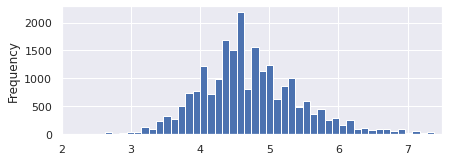

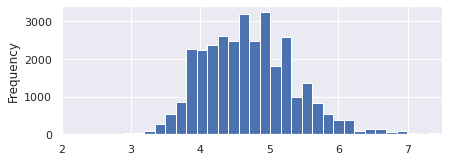

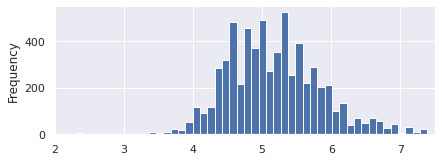

In [25]:
# Frequency distribution of th log of the price for every city
# Log price used for better view
fin_dataframe.select('log_price', 'city').toPandas().groupby('city').plot(kind='hist', bins=50, subplots=True, layout=(3, 2), legend=False, xlim=(2, 7.5), sharex=True)

This distribution tells us where does the average price range for each city falls
We see that the average price range in San Francisco is higher tyhan any other city and the highest and lowest rice both are in New York City

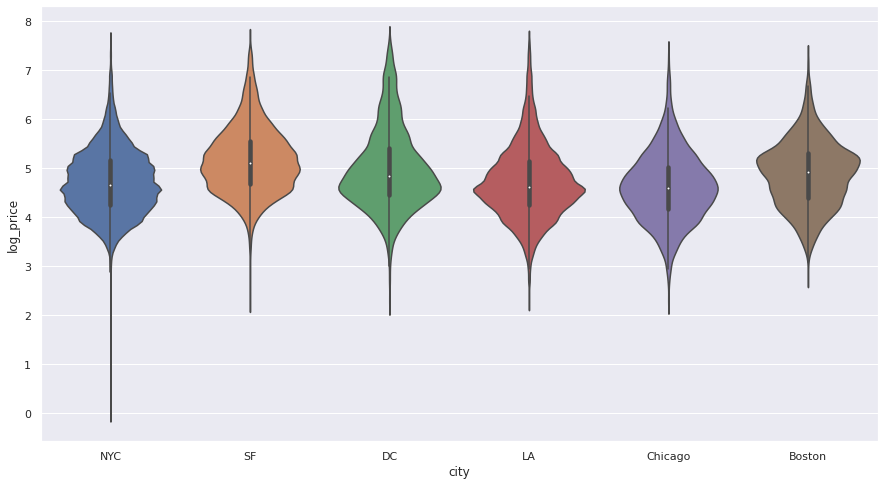

In [26]:
# Violin Plot shows same data as above but besides each other making comparison more easier
sb.violinplot(data=fin_dataframe.toPandas(), x='city', y='log_price')

#### Property type distribution

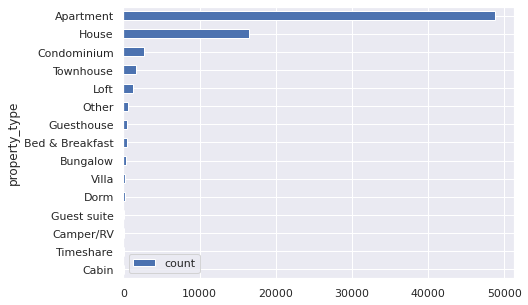

In [27]:
# Property type distribution as bar graph in desending order showing 15 most listed property type
fin_dataframe.groupBy('property_type').count().sort('count').toPandas()[-15:].plot(kind='barh', x='property_type', figsize=(7, 5))

This distribution shows us that most of the listing are apartments followed by house and then condominium. Out of the 15 given above Cabin are rare listings

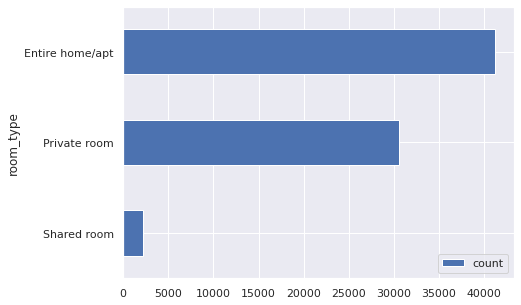

In [28]:
# Room Type distribution
fin_dataframe.groupBy('room_type').count().sort('count').toPandas().plot(kind='barh', x='room_type', figsize=(7, 5))

The distribution shows us that entire home or apartment are popular listings seconded by private room and least opular roomtype is shared.

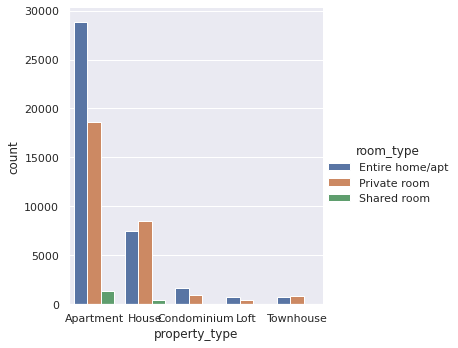

In [29]:
#Room Type vs Property Type Cat Plot
sb.catplot(data=fin_dataframe.select(['room_type', 'property_type']).where(fin_dataframe.property_type.isin(['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft'])).toPandas(), x='property_type', hue='room_type', kind='count')

The distribution above shows us room type distribution in 5 most popular property type. 
We can see that the entire home/apt is still the popular choie. Infact shared rooms only exist for apartment or house property_type

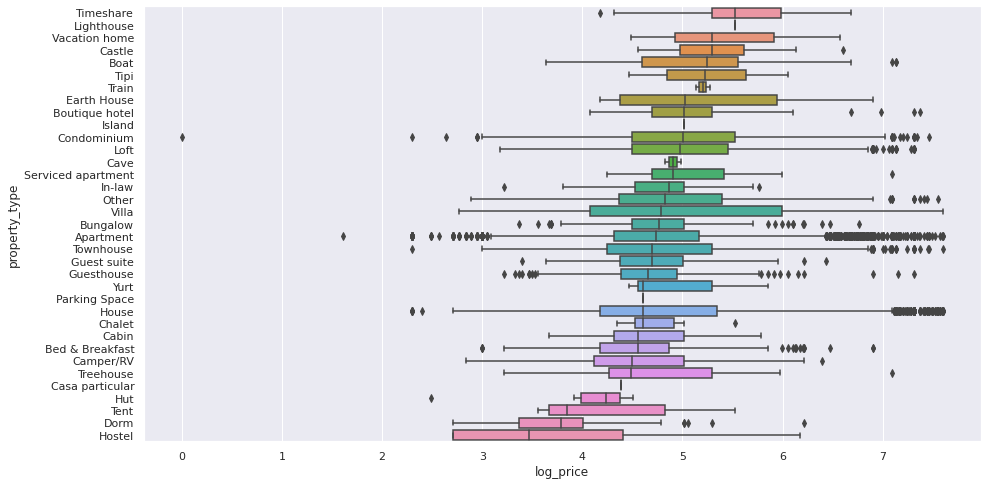

In [30]:
# Box Plots to show price distribution of property type with descending median price
ranks = fin_dataframe.toPandas().groupby("property_type")["log_price"].median().fillna(0).sort_values()[::-1].index
sb.boxplot(data=fin_dataframe.toPandas(), x='log_price', y='property_type', orient='h', order=ranks)

The above graph shows us that the price distribution of a given property type.
The lowest median price isfor hostels as properties and highest is for timeshare properties.

The largest distribution of price can be seen for houses, apartments and condominium with the later 2 have a lot of outliers taking up the space
Most outlier prices are seen for the property type apartment on either of the sides

Smallest price distribution is seen for parking space, casa particular and islands, seconded by cave and train properties


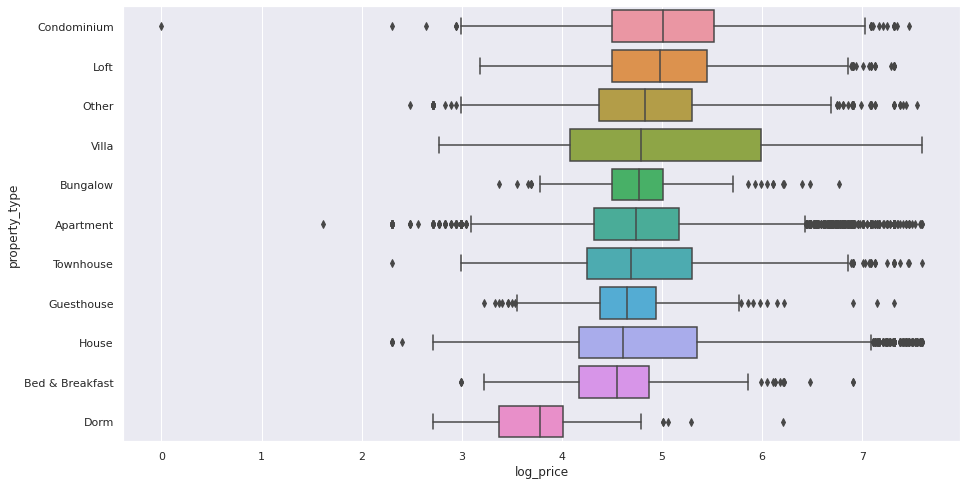

In [31]:
# We want to expand on price distribution of a few specified property types
df = fin_dataframe.withColumn("property_type", f.when(fin_dataframe.property_type.isin(['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft', 'Guesthouse', 'Bed & Breakfast', 'Bungalow', 'Villa', 'Dorm']), 
                                                fin_dataframe.property_type).otherwise('Other'))

ranks = df.toPandas().groupby("property_type")["log_price"].median().fillna(0).sort_values()[::-1].index
sb.boxplot(data=df.toPandas(), x='log_price', y='property_type', orient='h', order=ranks)

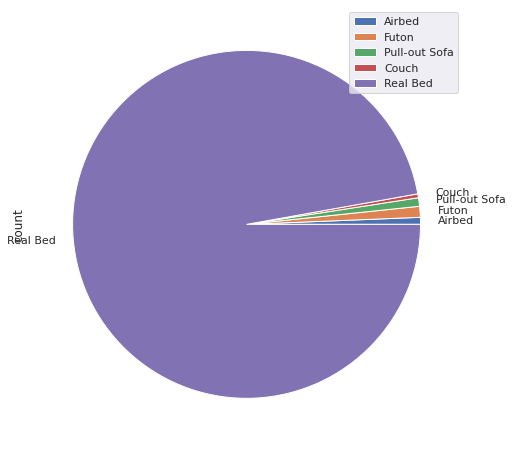

In [32]:
#Bed Type
fin_dataframe.groupBy(['bed_type']).count().toPandas().set_index('bed_type').plot(kind='pie', y='count')

The bed type here mainly falls under real bed as apposed to the other types.

#### Accomodates distribution

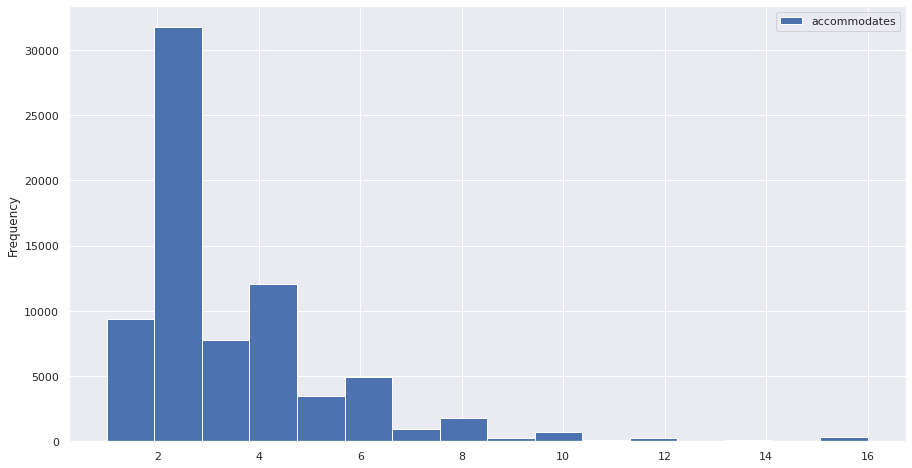

In [33]:
# Histogram for number of people that a listing accomodates
fin_dataframe.select('accommodates').toPandas().plot(kind='hist', bins =16)

From the above distribution we see that most of the properties listed accomodates 2 people.

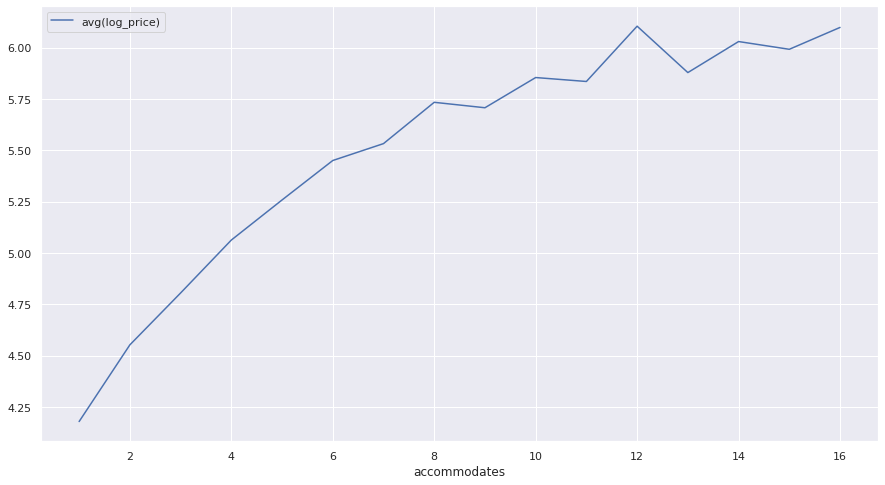

In [34]:
#Log Price vs Accomodates
fin_dataframe.select(['accommodates', 'log_price']).groupBy('accommodates').mean().sort('accommodates').toPandas().plot(x='accommodates', y='avg(log_price)')

From the above graph we can see that as the number of people a property can accomodate increases, so does the price which is common logic

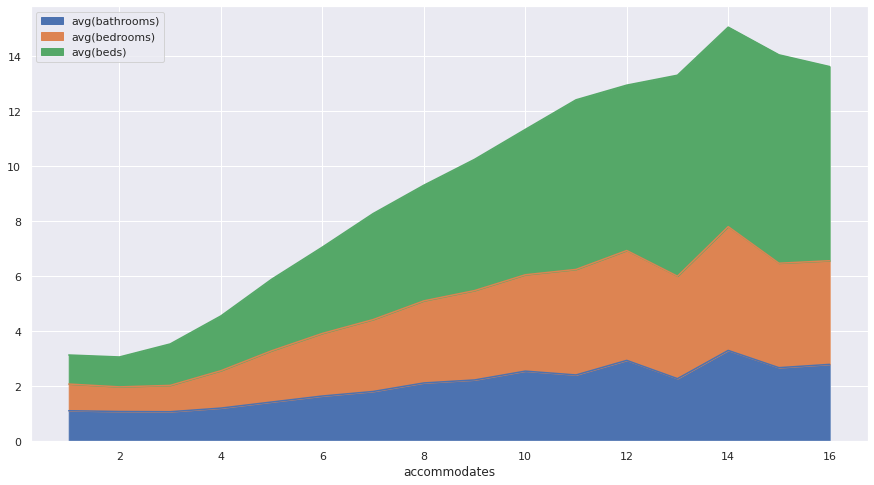

In [35]:
# bedromms/beds vs accommodates
df_by_acc = fin_dataframe.select('accommodates', 'bathrooms', 'bedrooms', 'beds').groupBy('accommodates').mean().toPandas().set_index('accommodates').sort_index()
df_by_acc.plot(kind='area', y=df_by_acc.columns.tolist()[1:])

From the above distribution we see that there is a considerable increase in number of beds/bedrooms as the number of people a property accocomodates increases
But there is not a significant increase in number of bathrooms as the accomadates number increases

#### Review Score rating distribution

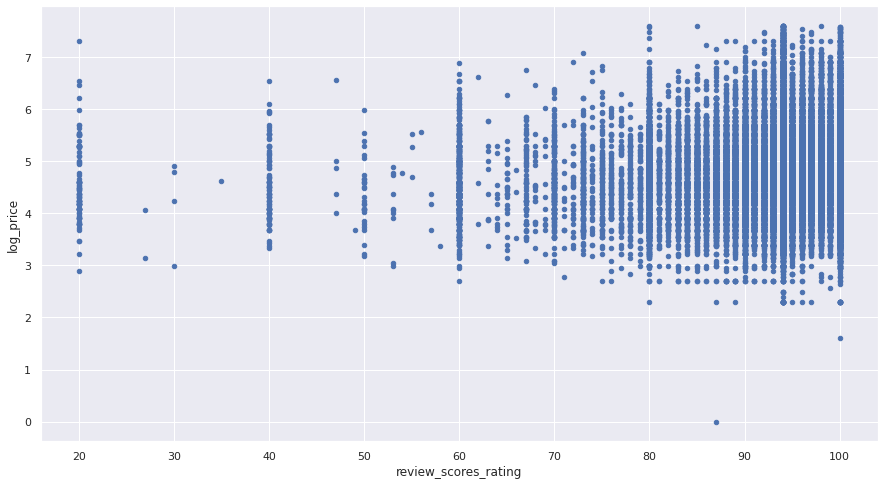

In [36]:
# Review Score Rating vs Log Price 
fin_dataframe.select(['review_scores_rating', 'log_price']).toPandas().plot(kind='scatter', x='review_scores_rating', y='log_price')

Review score rating here is a percentage and from the distribution we see that the density of rating for the listing falls towards a 100%.As the percentage decreases so does the number of property rated.

#### Cancellation Policy

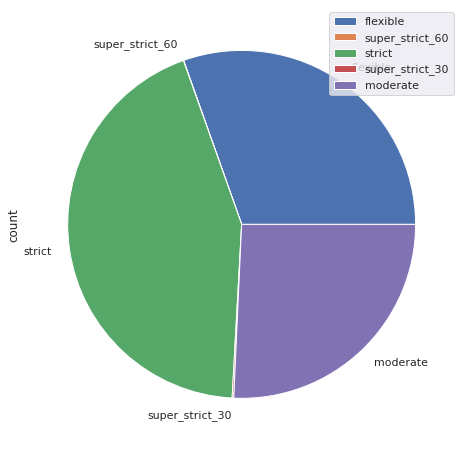

In [37]:
fin_dataframe.groupBy(['cancellation_policy']).count().toPandas().set_index('cancellation_policy').plot(kind='pie', y='count')

The cancellation policy falls under strict, but strict_30 and strict_60 is very low in perentage. Whereas flexible and moderate take up almost the same amount distribution

#### Cleaning Fee

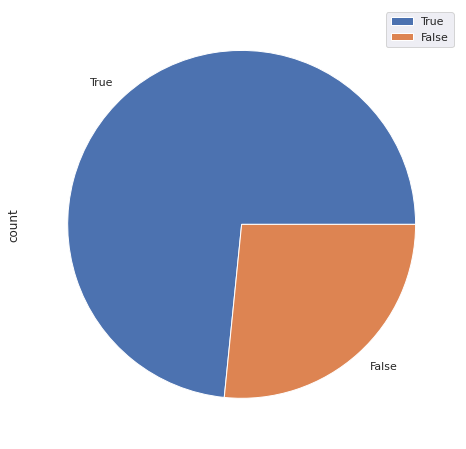

In [38]:
#Cleaning Fee Pie Chart
fin_dataframe.groupBy(['cleaning_fee']).count().toPandas().set_index('cleaning_fee').plot(kind='pie', y='count')

Most of the property listed do take cleaning fees

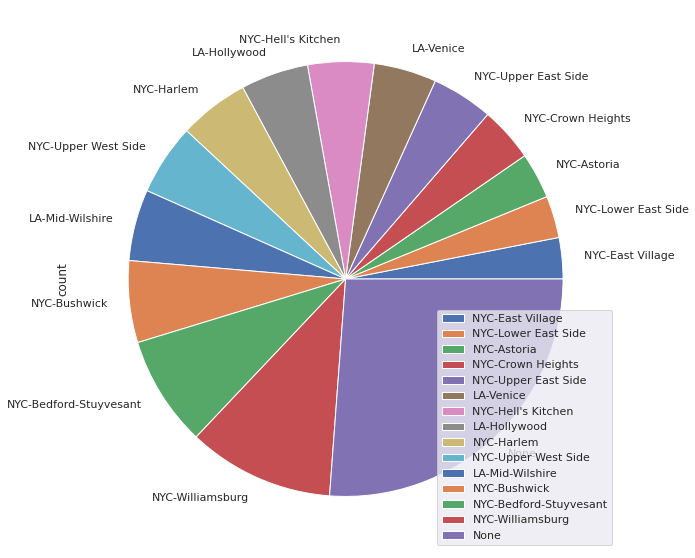

In [39]:
from pyspark.sql.functions import concat, col, lit, isnan

fin_dataframe = fin_dataframe.select("*", concat(col("city"),lit("-"),col("neighbourhood")).alias("city-neigh"))
sb.set(rc = {'figure.figsize':(20,10)})
fin_dataframe.filter(~isnan(col('neighbourhood'))).groupBy('city-neigh').count().sort('count').toPandas().set_index('city-neigh')[-15:].plot(kind='pie', y='count')

In [40]:
top_neigh = [x['city-neigh'] for x in fin_dataframe.groupBy('city-neigh').count().sort(col('count').desc()).head(200)]
fin_dataframe = fin_dataframe.withColumn("city-neigh", when(fin_dataframe['city-neigh'].isin(top_neigh) & ~fin_dataframe['city-neigh'].like('%NaN'), fin_dataframe['city-neigh']).otherwise(fin_dataframe['city']))

In [41]:
#Neighborhood Prices
df_neigh_gr_pd = fin_dataframe.groupBy("city-neigh").agg(f.mean("price").alias("mean_price")).orderBy('mean_price', ascending=False).toPandas()
df_neigh_gr_pd

,city-neigh,mean_price
0,LA-Bel Air/Beverly Crest,531.115385
1,LA-Malibu,523.923913
2,LA-Pacific Palisades,386.265625
3,LA-Laurel Canyon,382.051852
4,NYC-Tribeca,360.233010
...,...,...
200,LA-Alhambra,78.052632
201,NYC-Ridgewood,77.286822
202,NYC-Elmhurst,75.465116
203,NYC-Sunset Park,74.888889


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


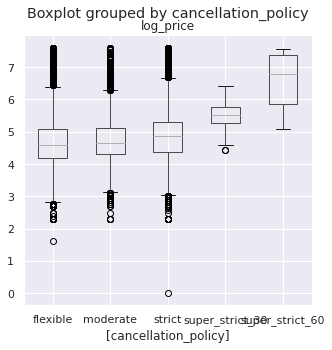

In [42]:
#Cancellation Policy vs log price
fin_dataframe.select(['cancellation_policy', 'log_price']).toPandas().boxplot(by='cancellation_policy', figsize=(5, 5))

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


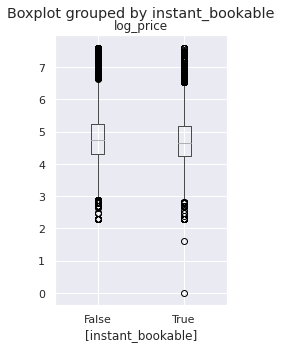

In [43]:

fin_dataframe.select(['instant_bookable', 'log_price']).toPandas().boxplot(by='instant_bookable', figsize=(3, 5))

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


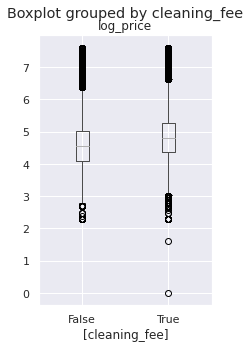

In [44]:
#
fin_dataframe.select(['cleaning_fee', 'log_price']).toPandas().boxplot(by='cleaning_fee', figsize=(3, 5))

In [45]:
#Most of the listings have a simple bed, and instant_bookable column 
#doesn't influence the price strong enough. I guess, we can just drop this columns, as well as number of beds - it correlates with 'accommodates' too much
fin_dataframe = fin_dataframe.drop('instant_bookable', 'bed_type', 'bedrooms', 'bathrooms', 'beds','amenities')

#New ones for vectorization
fin_dataframe = fin_dataframe.drop('description', 'first_review', 'host_has_profile_pic', 
                                   'host_identity_verified', 'host_since','amenities', 'thumbnail_url', 'name', 'neighbourhood', 'last_review',
                                   'latitude','longitude','zipcode','last_review_days','Price','Pets_live_on_this_property')


In [46]:
fin_dataframe.dtypes

[('id', 'int'),
 ('log_price', 'double'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('accommodates', 'int'),
 ('cancellation_policy', 'string'),
 ('cleaning_fee', 'boolean'),
 ('city', 'string'),
 ('host_response_rate', 'int'),
 ('number_of_reviews', 'int'),
 ('review_scores_rating', 'double'),
 ('first_review_days', 'int'),
 ('host_since_days', 'int'),
 ('Kitchen', 'boolean'),
 ('Heating', 'boolean'),
 ('TV', 'boolean'),
 ('Hair_dryer', 'boolean'),
 ('Washer', 'boolean'),
 ('Dryer', 'boolean'),
 ('Iron', 'boolean'),
 ('Familykid_friendly', 'boolean'),
 ('Cable_TV', 'boolean'),
 ('24-hour_check-in', 'boolean'),
 ('Elevator', 'boolean'),
 ('Indoor_fireplace', 'boolean'),
 ('Gym', 'boolean'),
 ('Private_entrance', 'boolean'),
 ('Doorman', 'boolean'),
 ('Suitable_for_events', 'boolean'),
 ('city-neigh', 'string')]

In [47]:
fin_dataframe.toPandas().isna().sum()

id                      0
log_price               0
property_type           0
room_type               0
accommodates            0
cancellation_policy     0
cleaning_fee            0
city                    0
host_response_rate      0
number_of_reviews       0
review_scores_rating    0
first_review_days       0
host_since_days         0
Kitchen                 0
Heating                 0
TV                      0
Hair_dryer              0
Washer                  0
Dryer                   0
Iron                    0
Familykid_friendly      0
Cable_TV                0
24-hour_check-in        0
Elevator                0
Indoor_fireplace        0
Gym                     0
Private_entrance        0
Doorman                 0
Suitable_for_events     0
city-neigh              0
dtype: int64

In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MaxAbsScaler

In [49]:
# all the string variables from above need to be added over here
#cat_cols = ['property_type', 'room_type', 'cancellation_policy', 'city-neigh']
cat_cols = ['property_type', 'room_type', 'cancellation_policy', 'city-neigh']
indexers = [StringIndexer(inputCol= c, outputCol= c + "_ind") for c in cat_cols]
encoders = [OneHotEncoder(inputCol= c+"_ind", outputCol= c+ "_one_hot") for c in cat_cols]
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(fin_dataframe).transform(fin_dataframe)

In [50]:
df_vectorized = df_encoded.drop(*cat_cols, *[c + '_ind' for c in cat_cols], 'city')

In [51]:
len(df_vectorized.columns)

29

In [52]:
df_cols = df_vectorized.columns[2:-4]
df_cols

['accommodates',
 'cleaning_fee',
 'host_response_rate',
 'number_of_reviews',
 'review_scores_rating',
 'first_review_days',
 'host_since_days',
 'Kitchen',
 'Heating',
 'TV',
 'Hair_dryer',
 'Washer',
 'Dryer',
 'Iron',
 'Familykid_friendly',
 'Cable_TV',
 '24-hour_check-in',
 'Elevator',
 'Indoor_fireplace',
 'Gym',
 'Private_entrance',
 'Doorman',
 'Suitable_for_events']

In [53]:
assembler = VectorAssembler(
    inputCols=[col for col in df_vectorized.columns if col not in ['id', 'log_price']],
    outputCol="features")
df_vectorized = assembler.transform(df_vectorized).select(['id', 'features', 'log_price'])
df_vectorized.head()

Row(id=6901257, features=SparseVector(267, {0: 3.0, 1: 1.0, 3: 2.0, 4: 100.0, 5: 2770.0, 6: 1484.0, 7: 1.0, 8: 1.0, 10: 1.0, 13: 1.0, 14: 1.0, 23: 1.0, 57: 1.0, 59: 1.0, 218: 1.0}), log_price=5.010635294)

In [54]:
scaler = MaxAbsScaler(inputCol='features', outputCol='features_scaled')
df_vectorized = scaler.fit(df_vectorized).transform(df_vectorized)

In [55]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=150, featuresCol="features_scaled",
                         outputCol="features_selected", labelCol="log_price")

df_vectorized = selector.fit(df_vectorized).transform(df_vectorized)

In [56]:
df_vectorized.columns

['id', 'features', 'log_price', 'features_scaled', 'features_selected']

In [57]:
from pyspark.ml.feature import PCA

pca_model = PCA(k=100,inputCol = "features_scaled", outputCol = "pca_features")
df_vectorized = pca_model.fit(df_vectorized).transform(df_vectorized)

In [58]:
from pyspark.ml.feature import PolynomialExpansion

px = PolynomialExpansion(degree=2, inputCol='features_scaled', outputCol='poly_features')
df_vectorized = px.transform(df_vectorized)

In [59]:
train_df, test_df = df_vectorized.randomSplit([0.8, 0.2])
#train_df.count(), test_df.count()

In [60]:
# print(features_scaled)
# print(pca_features)
# print(poly_features)
df_vectorized.show()

+--------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|      id|            features|  log_price|     features_scaled|   features_selected|        pca_features|       poly_features|
+--------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
| 6901257|(267,[0,1,3,4,5,6...|5.010635294|(267,[0,1,3,4,5,6...|(150,[0,1,3,4,5,6...|[-1.7660803025292...|(36045,[0,1,2,3,4...|
| 6304928|(267,[0,1,2,3,4,5...|5.129898715|(267,[0,1,2,3,4,5...|(150,[0,1,2,3,4,5...|[-2.4606629251351...|(36045,[0,1,2,3,4...|
| 7919400|(267,[0,1,2,3,4,5...|4.976733742|(267,[0,1,2,3,4,5...|(150,[0,1,2,3,4,5...|[-2.1606321300817...|(36045,[0,1,2,3,4...|
|13418779|(267,[0,1,4,5,6,7...|6.620073207|(267,[0,1,4,5,6,7...|(150,[0,1,3,4,5,6...|[-1.5838532787337...|(36045,[0,1,2,3,4...|
| 3808709|(267,[0,1,2,3,4,5...|4.744932128|(267,[0,1,2,3,4,5...|(150,[0,1,2,3,4,5...|[-1.1419007433109..

In [61]:
def train_and_evaluate(dt, train_df, test_df):
    dt_model = dt.fit(train_df)
    dt_train_pred = dt_model.transform(train_df)
    dt_test_pred = dt_model.transform(test_df)
    dt_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction")
    rmse_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "rmse"})
    mae_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "mae"})
    rmse_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "rmse"})
    mae_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "mae"})
    print("RMSE on train data = %g" % rmse_train)
    print("MAE on train data = %g" % mae_train)
    print("RMSE on test data = %g" % rmse_test)
    print("MAE on test data = %g" % mae_test)
    return dt_model

Linear Regrssion

with features_scaled

In [62]:
lr = LinearRegression(maxIter=100, labelCol='log_price', featuresCol='features_scaled')
lr_model = train_and_evaluate(lr, train_df, test_df)


RMSE on train data = 0.436148
MAE on train data = 0.318744
RMSE on test data = 0.421019
MAE on test data = 0.313056


In [63]:
inter = lr_model.intercept
coefs = lr_model.coefficients

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","log_price","features_scaled").show(10)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------------+
|        prediction|  log_price|     features_scaled|
+------------------+-----------+--------------------+
| 4.454023756970843|4.382026635|(267,[0,2,3,4,5,6...|
| 4.718176080094103|4.553876892|(267,[0,1,3,4,5,6...|
|5.6440222316187825|5.416100402|(267,[0,1,2,3,4,5...|
| 4.765738112447372|  4.8978398|(267,[0,1,2,3,4,5...|
| 4.545388711881184|4.787491743|(267,[0,1,2,4,5,6...|
|4.5821846034545395|4.691347882|(267,[0,1,2,3,4,5...|
|4.4504236371269235|4.700480366|(267,[0,4,5,6,7,9...|
| 5.059501029094318|5.342334252|(267,[0,1,2,3,4,5...|
| 4.726699716750199|4.584967479|(267,[0,3,4,5,6,7...|
|4.1284468556345395| 4.17438727|(267,[0,2,3,4,5,6...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.649234


In [91]:
lr_predictions_t = lr_model.transform(train_df)
lr_predictions_t.select("prediction","log_price","features_scaled").show(10)

lr_evaluator_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % lr_evaluator_t.evaluate(lr_predictions_t))

+------------------+-----------+--------------------+
|        prediction|  log_price|     features_scaled|
+------------------+-----------+--------------------+
|  4.88448903474608|5.075173815|(267,[0,1,2,3,4,5...|
| 4.588011045566012|4.317488114|(267,[0,1,2,3,4,5...|
|  5.27857448597085|4.624972813|(267,[0,3,4,5,6,7...|
| 5.428908676927713|5.298317367|(267,[0,1,2,3,4,5...|
|4.9833876512384325|4.605170186|(267,[0,1,3,4,5,6...|
| 4.135391274077684|4.077537444|(267,[0,1,2,3,4,5...|
| 4.573474103908436|5.010635294|(267,[0,1,2,3,4,5...|
| 4.981127352976265| 4.17438727|(267,[0,1,2,3,4,5...|
| 5.420209270613462|4.905274778|(267,[0,1,2,3,4,5...|
| 5.264142234604709|5.370638028|(267,[0,1,2,3,4,5...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.632311


with features_selected

In [64]:
lr_fs = LinearRegression(maxIter=100, labelCol='log_price', featuresCol='features_selected')
lr_model_fs = train_and_evaluate(lr_fs, train_df, test_df)

RMSE on train data = 0.449593
MAE on train data = 0.331071
RMSE on test data = 0.434524
MAE on test data = 0.324948


In [65]:
inter_fs = lr_model_fs.intercept
coefs_fs = lr_model_fs.coefficients

lr_predictions_fs = lr_model_fs.transform(test_df)
lr_predictions_fs.select("prediction","log_price","features_selected").show(10)
lr_evaluator_fs = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_fs.evaluate(lr_predictions_fs))

+-----------------+-----------+--------------------+
|       prediction|  log_price|   features_selected|
+-----------------+-----------+--------------------+
|4.538847646057751|4.382026635|(150,[0,2,3,4,5,7...|
|4.735714713613224|4.553876892|(150,[0,1,3,4,5,6...|
|5.633786236897552|5.416100402|(150,[0,1,2,3,4,5...|
|4.774096578932285|  4.8978398|(150,[0,1,2,3,4,5...|
|4.503574910449437|4.787491743|(150,[0,1,2,3,4,5...|
|4.835174289596459|4.691347882|(150,[0,1,2,3,4,5...|
|4.452565537314067|4.700480366|(150,[0,3,4,5,7,8...|
|5.049252477248177|5.342334252|(150,[0,1,2,3,4,5...|
|4.741954846126984|4.584967479|(150,[0,3,4,5,6,9...|
|4.071398979734533| 4.17438727|(150,[0,2,3,4,5,6...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.62637


In [92]:
lr_predictions_fs_t = lr_model_fs.transform(train_df)
lr_predictions_fs_t.select("prediction","log_price","features_selected").show(10)
lr_evaluator_fs_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % lr_evaluator_fs_t.evaluate(lr_predictions_fs_t))

+------------------+-----------+--------------------+
|        prediction|  log_price|   features_selected|
+------------------+-----------+--------------------+
| 4.880492251526834|5.075173815|(150,[0,1,2,3,4,5...|
| 4.473053936301983|4.317488114|(150,[0,1,2,3,4,5...|
| 5.304437349779213|4.624972813|(150,[0,3,4,5,6,7...|
|5.5243041714423216|5.298317367|(150,[0,1,2,3,4,5...|
|  4.99422578332732|4.605170186|(150,[0,1,3,4,5,6...|
| 4.117556336000105|4.077537444|(150,[0,1,2,3,4,7...|
|4.5551896741441436|5.010635294|(150,[0,1,2,3,4,5...|
| 4.996897319191522| 4.17438727|(150,[0,1,2,3,4,5...|
| 5.627170152235651|4.905274778|(150,[0,1,2,3,4,5...|
| 5.317977302631894|5.370638028|(150,[0,1,2,3,4,5...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.609293


With pca features

In [66]:
lr_pca = LinearRegression(maxIter=100, labelCol='log_price', featuresCol='pca_features')
lr_model_pca = train_and_evaluate(lr_pca, train_df, test_df)


RMSE on train data = 0.464181
MAE on train data = 0.342692
RMSE on test data = 0.448545
MAE on test data = 0.336481


In [67]:
inter_pca = lr_model_pca.intercept
coefs_pca = lr_model_pca.coefficients

lr_predictions_pca = lr_model_pca.transform(test_df)
lr_predictions_pca.select("prediction","log_price","pca_features").show(10)
lr_evaluator_pca = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_pca.evaluate(lr_predictions_pca))

+------------------+-----------+--------------------+
|        prediction|  log_price|        pca_features|
+------------------+-----------+--------------------+
| 4.673474145346165|4.382026635|[-0.7211706400848...|
|  4.73862540730023|4.553876892|[-0.8727212184889...|
| 5.622051706634242|5.416100402|[-1.9054033369638...|
|  4.67576701049741|  4.8978398|[-2.7475970448731...|
|  4.47314275268054|4.787491743|[-1.6469919306280...|
| 4.942578444835499|4.691347882|[-2.4700482189456...|
| 4.455501865991317|4.700480366|[-0.2140974589103...|
|  5.06709914286149|5.342334252|[-2.6056028353701...|
| 4.752752215408572|4.584967479|[-0.7404898502813...|
|4.1535225475644735| 4.17438727|[-0.8377419692287...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.601869


In [93]:
lr_predictions_pca_t = lr_model_pca.transform(train_df)
lr_predictions_pca_t.select("prediction","log_price","pca_features").show(10)
lr_evaluator_pca_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % lr_evaluator_pca_t.evaluate(lr_predictions_pca_t))

+-----------------+-----------+--------------------+
|       prediction|  log_price|        pca_features|
+-----------------+-----------+--------------------+
|4.894794996295259|5.075173815|[-1.9350791200458...|
|4.598444454303667|4.317488114|[-1.7258898102808...|
|5.314605883842656|4.624972813|[-0.4586245029870...|
|5.371524293890583|5.298317367|[-1.2875542689598...|
|5.003162558748022|4.605170186|[-2.0077952989924...|
|4.125615186475653|4.077537444|[-1.0068594265392...|
|4.550859924673208|5.010635294|[-1.6227504580676...|
|4.995229614780736| 4.17438727|[-2.2501145888148...|
|5.731510093034947|4.905274778|[-2.6419146436059...|
|5.334406146645488|5.370638028|[-2.5628938292298...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.583526


Decision Tree

with features_scaled

In [70]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features_scaled', labelCol = 'log_price')
dt_model = train_and_evaluate(dt, train_df, test_df)

RMSE on train data = 0.500808
MAE on train data = 0.380792
RMSE on test data = 0.485538
MAE on test data = 0.374619


In [71]:
dt_predictions = dt_model.transform(test_df)
dt_predictions.select("prediction","log_price","features_scaled").show(10)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dt_predictions))

+------------------+-----------+--------------------+
|        prediction|  log_price|     features_scaled|
+------------------+-----------+--------------------+
| 4.357645096147558|4.382026635|(267,[0,2,3,4,5,6...|
| 4.357645096147558|4.553876892|(267,[0,1,3,4,5,6...|
|5.8743081554048775|5.416100402|(267,[0,1,2,3,4,5...|
| 4.853561277936281|  4.8978398|(267,[0,1,2,3,4,5...|
| 4.501277862260667|4.787491743|(267,[0,1,2,4,5,6...|
| 4.853561277936281|4.691347882|(267,[0,1,2,3,4,5...|
| 4.407862225258928|4.700480366|(267,[0,4,5,6,7,9...|
| 5.309093059977063|5.342334252|(267,[0,1,2,3,4,5...|
| 4.853561277936281|4.584967479|(267,[0,3,4,5,6,7...|
| 4.111553039247746| 4.17438727|(267,[0,2,3,4,5,6...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.533489


In [94]:
dt_predictions_t = dt_model.transform(train_df)
dt_predictions_t.select("prediction","log_price","features_scaled").show(10)
dt_evaluator_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % dt_evaluator_t.evaluate(dt_predictions_t))

+-----------------+-----------+--------------------+
|       prediction|  log_price|     features_scaled|
+-----------------+-----------+--------------------+
|5.309093059977063|5.075173815|(267,[0,1,2,3,4,5...|
|4.357645096147558|4.317488114|(267,[0,1,2,3,4,5...|
|4.853561277936281|4.624972813|(267,[0,3,4,5,6,7...|
|5.582835843828122|5.298317367|(267,[0,1,2,3,4,5...|
|5.058558930780839|4.605170186|(267,[0,1,3,4,5,6...|
|4.128797416349576|4.077537444|(267,[0,1,2,3,4,5...|
|4.357645096147558|5.010635294|(267,[0,1,2,3,4,5...|
|5.058558930780839| 4.17438727|(267,[0,1,2,3,4,5...|
|5.577328002620862|4.905274778|(267,[0,1,2,3,4,5...|
|4.853561277936281|5.370638028|(267,[0,1,2,3,4,5...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.515207


with pca_features

In [72]:
dt_pca = DecisionTreeRegressor(featuresCol ='pca_features', labelCol = 'log_price')
dt_model_pca = train_and_evaluate(dt_pca, train_df, test_df)

RMSE on train data = 0.547702
MAE on train data = 0.41206
RMSE on test data = 0.531103
MAE on test data = 0.40412


In [73]:
dt_predictions_pca = dt_model_pca.transform(test_df)
dt_predictions_pca.select("prediction","log_price","pca_features").show(10)
dt_evaluator_pca = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator_pca.evaluate(dt_predictions_pca))

+-----------------+-----------+--------------------+
|       prediction|  log_price|        pca_features|
+-----------------+-----------+--------------------+
|4.315621221125397|4.382026635|[-0.7211706400848...|
|4.315621221125397|4.553876892|[-0.8727212184889...|
|5.386168858759252|5.416100402|[-1.9054033369638...|
|4.962646832092832|  4.8978398|[-2.7475970448731...|
|4.315621221125397|4.787491743|[-1.6469919306280...|
|4.962646832092832|4.691347882|[-2.4700482189456...|
|4.315621221125397|4.700480366|[-0.2140974589103...|
|5.386168858759252|5.342334252|[-2.6056028353701...|
|4.917616480758242|4.584967479|[-0.7404898502813...|
|4.315621221125397| 4.17438727|[-0.8377419692287...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.441821


In [96]:
dt_predictions_pca_t = dt_model_pca.transform(train_df)
dt_predictions_pca_t.select("prediction","log_price","pca_features").show(10)
dt_evaluator_pca_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % dt_evaluator_pca_t.evaluate(dt_predictions_pca_t))

+------------------+-----------+--------------------+
|        prediction|  log_price|        pca_features|
+------------------+-----------+--------------------+
| 5.386168858759252|5.075173815|[-1.9350791200458...|
| 4.315621221125397|4.317488114|[-1.7258898102808...|
| 5.116529195695687|4.624972813|[-0.4586245029870...|
| 5.415171118359871|5.298317367|[-1.2875542689598...|
| 4.962646832092832|4.605170186|[-2.0077952989924...|
| 4.315621221125397|4.077537444|[-1.0068594265392...|
| 4.315621221125397|5.010635294|[-1.6227504580676...|
| 4.962646832092832| 4.17438727|[-2.2501145888148...|
|5.4748217188173625|4.905274778|[-2.6419146436059...|
| 4.962646832092832|5.370638028|[-2.5628938292298...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.42017


Random Forest

with features_scaled

In [76]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol ='features_scaled', labelCol = 'log_price', numTrees=10)
rf_model = train_and_evaluate(rf, train_df, test_df)

RMSE on train data = 0.507943
MAE on train data = 0.38354
RMSE on test data = 0.491161
MAE on test data = 0.37556


In [77]:
rf_predictions = rf_model.transform(test_df)
rf_predictions.select("prediction","log_price","features_scaled").show(10)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rf_predictions))

+------------------+-----------+--------------------+
|        prediction|  log_price|     features_scaled|
+------------------+-----------+--------------------+
| 4.357618096533898|4.382026635|(267,[0,2,3,4,5,6...|
|4.5064951679772065|4.553876892|(267,[0,1,3,4,5,6...|
| 5.317915269397263|5.416100402|(267,[0,1,2,3,4,5...|
| 5.026332188729365|  4.8978398|(267,[0,1,2,3,4,5...|
|4.4500633308541016|4.787491743|(267,[0,1,2,4,5,6...|
| 5.049074937644493|4.691347882|(267,[0,1,2,3,4,5...|
|  4.38941427221501|4.700480366|(267,[0,4,5,6,7,9...|
| 5.169606025438607|5.342334252|(267,[0,1,2,3,4,5...|
| 4.917557192899262|4.584967479|(267,[0,3,4,5,6,7...|
| 4.140124315315912| 4.17438727|(267,[0,2,3,4,5,6...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.522622


In [97]:
rf_predictions_t = rf_model.transform(train_df)
rf_predictions_t.select("prediction","log_price","features_scaled").show(10)
rf_evaluator_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % rf_evaluator_t.evaluate(rf_predictions_t))

+-----------------+-----------+--------------------+
|       prediction|  log_price|     features_scaled|
+-----------------+-----------+--------------------+
| 5.04845640502541|5.075173815|(267,[0,1,2,3,4,5...|
|  4.3675396924691|4.317488114|(267,[0,1,2,3,4,5...|
|4.961703906178829|4.624972813|(267,[0,3,4,5,6,7...|
| 5.52841759192369|5.298317367|(267,[0,1,2,3,4,5...|
|5.089070561966607|4.605170186|(267,[0,1,3,4,5,6...|
|4.357618096533898|4.077537444|(267,[0,1,2,3,4,5...|
|4.357618096533898|5.010635294|(267,[0,1,2,3,4,5...|
|5.048434777187269| 4.17438727|(267,[0,1,2,3,4,5...|
|5.679335012259579|4.905274778|(267,[0,1,2,3,4,5...|
|5.119962474330611|5.370638028|(267,[0,1,2,3,4,5...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.501296


with pca_features

In [78]:
rf_pca = RandomForestRegressor(featuresCol ='pca_features', labelCol = 'log_price', numTrees=10)
rf_model_pca = train_and_evaluate(rf_pca, train_df, test_df)

RMSE on train data = 0.533884
MAE on train data = 0.401094
RMSE on test data = 0.51743
MAE on test data = 0.394489


In [101]:
rf_predictions_pca = rf_model_pca.transform(test_df)
rf_predictions_pca.select("prediction","log_price","pca_features").show(10)
rf_evaluator_pca = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator_pca.evaluate(rf_predictions_pca))

+-----------------+-----------+--------------------+
|       prediction|  log_price|        pca_features|
+-----------------+-----------+--------------------+
|4.555025731854417|4.382026635|[-0.7211706400848...|
|  4.5310829846954|4.553876892|[-0.8727212184889...|
| 5.41165302855201|5.416100402|[-1.9054033369638...|
|4.984767889802674|  4.8978398|[-2.7475970448731...|
|4.486855481088833|4.787491743|[-1.6469919306280...|
|5.026303242823795|4.691347882|[-2.4700482189456...|
|4.504386729113316|4.700480366|[-0.2140974589103...|
|5.116456874067014|5.342334252|[-2.6056028353701...|
|4.776503040783659|4.584967479|[-0.7404898502813...|
|4.348657864885323| 4.17438727|[-0.8377419692287...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.470193


In [99]:
rf_predictions_pca_t = rf_model_pca.transform(train_df)
rf_predictions_pca_t.select("prediction","log_price","pca_features").show(10)
rf_evaluator_pca_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % rf_evaluator_pca_t.evaluate(rf_predictions_pca_t))

+------------------+-----------+--------------------+
|        prediction|  log_price|        pca_features|
+------------------+-----------+--------------------+
|  5.09523759127805|5.075173815|[-1.9350791200458...|
| 4.814995385891492|4.317488114|[-1.7258898102808...|
|4.9574358840121935|4.624972813|[-0.4586245029870...|
| 5.040505158054087|5.298317367|[-1.2875542689598...|
| 4.986520135341521|4.605170186|[-2.0077952989924...|
|4.3206938438918305|4.077537444|[-1.0068594265392...|
|   4.4642185901197|5.010635294|[-1.6227504580676...|
| 4.984435235424436| 4.17438727|[-2.2501145888148...|
| 5.211291776281689|4.905274778|[-2.6419146436059...|
| 4.990355024370724|5.370638028|[-2.5628938292298...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.449057


CV Random Forest

In [82]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor


rf = RandomForestRegressor(labelCol = "log_price", featuresCol = "features_scaled")
ppl_cv = Pipeline(stages = [rf])

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [20, 30, 50, 100]).addGrid(rf.minInstancesPerNode, [1, 10, 100]).build()

crossval = CrossValidator(estimator = ppl_cv,
                          estimatorParamMaps=paramGrid,
                          evaluator = RegressionEvaluator(labelCol="log_price", metricName="mae"),
                          numFolds= 3)
cv_model = train_and_evaluate(crossval, train_df, test_df)

RMSE on train data = 0.499315
MAE on train data = 0.377774
RMSE on test data = 0.482931
MAE on test data = 0.370442


In [83]:
cv_predictions = cv_model.transform(test_df)
cv_predictions.select("prediction","log_price","features_scaled").show(10)
cv_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % cv_evaluator.evaluate(cv_predictions))

+-----------------+-----------+--------------------+
|       prediction|  log_price|     features_scaled|
+-----------------+-----------+--------------------+
|4.358370104980978|4.382026635|(267,[0,2,3,4,5,6...|
|4.564143974924071|4.553876892|(267,[0,1,3,4,5,6...|
|5.302555226568455|5.416100402|(267,[0,1,2,3,4,5...|
|4.964975670373435|  4.8978398|(267,[0,1,2,3,4,5...|
| 4.49160203346948|4.787491743|(267,[0,1,2,4,5,6...|
|4.985124351624761|4.691347882|(267,[0,1,2,3,4,5...|
| 4.42783173184946|4.700480366|(267,[0,4,5,6,7,9...|
|5.254009252864156|5.342334252|(267,[0,1,2,3,4,5...|
|4.862416887946647|4.584967479|(267,[0,3,4,5,6,7...|
|4.132726490587094| 4.17438727|(267,[0,2,3,4,5,6...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.538486


In [100]:
cv_predictions_t = cv_model.transform(train_df)
cv_predictions_t.select("prediction","log_price","features_scaled").show(10)
cv_evaluator_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % cv_evaluator_t.evaluate(cv_predictions_t))

+------------------+-----------+--------------------+
|        prediction|  log_price|     features_scaled|
+------------------+-----------+--------------------+
|  5.16431479509181|5.075173815|(267,[0,1,2,3,4,5...|
|4.4238424762620525|4.317488114|(267,[0,1,2,3,4,5...|
| 4.915734356755425|4.624972813|(267,[0,3,4,5,6,7...|
|  5.46624419365155|5.298317367|(267,[0,1,2,3,4,5...|
| 5.134445885518229|4.605170186|(267,[0,1,3,4,5,6...|
| 4.260369033853995|4.077537444|(267,[0,1,2,3,4,5...|
| 4.355459395859267|5.010635294|(267,[0,1,2,3,4,5...|
| 5.082247620936115| 4.17438727|(267,[0,1,2,3,4,5...|
| 5.538296544446888|4.905274778|(267,[0,1,2,3,4,5...|
| 4.998108861176789|5.370638028|(267,[0,1,2,3,4,5...|
+------------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.518095


Polynomial regression

In [88]:
#Polynomial regression gets better on train data, but starts to overfit. Let's try some regularisation technique:
pr = LinearRegression(maxIter=500, labelCol='log_price', featuresCol='poly_features', elasticNetParam=0.2, regParam=0.02)
pr_model = train_and_evaluate(pr, train_df, test_df)
print("numIterations: %d" % lr_model.summary.totalIterations)

RMSE on train data = 0.418251
MAE on train data = 0.305692
RMSE on test data = 0.407996
MAE on test data = 0.302353
numIterations: 80


In [102]:
pr_predictions = pr_model.transform(test_df)
pr_predictions.select("prediction","log_price","features").show(10)
from pyspark.ml.evaluation import RegressionEvaluator
pr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on test data = %g" % pr_evaluator.evaluate(pr_predictions))

+-----------------+-----------+--------------------+
|       prediction|  log_price|            features|
+-----------------+-----------+--------------------+
|4.379632658216533|4.382026635|(267,[0,2,3,4,5,6...|
|4.601409620060208|4.553876892|(267,[0,1,3,4,5,6...|
|5.572851302136012|5.416100402|(267,[0,1,2,3,4,5...|
|4.908279618120939|  4.8978398|(267,[0,1,2,3,4,5...|
|4.506754204854987|4.787491743|(267,[0,1,2,4,5,6...|
|4.755646170508877|4.691347882|(267,[0,1,2,3,4,5...|
|4.375255656264168|4.700480366|(267,[0,4,5,6,7,9...|
| 5.04985158282102|5.342334252|(267,[0,1,2,3,4,5...|
|4.738616581641972|4.584967479|(267,[0,3,4,5,6,7...|
|4.069070959189249| 4.17438727|(267,[0,2,3,4,5,6...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.670597


In [103]:
pr_predictions_t = pr_model.transform(train_df)
pr_predictions_t.select("prediction","log_price","features").show(10)
from pyspark.ml.evaluation import RegressionEvaluator
pr_evaluator_t = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
print("R Squared (R2) on train data = %g" % pr_evaluator_t.evaluate(pr_predictions_t))

+-----------------+-----------+--------------------+
|       prediction|  log_price|            features|
+-----------------+-----------+--------------------+
|4.878003935518662|5.075173815|(267,[0,1,2,3,4,5...|
|4.513679737004427|4.317488114|(267,[0,1,2,3,4,5...|
| 5.16970299843214|4.624972813|(267,[0,3,4,5,6,7...|
|5.336056889352479|5.298317367|(267,[0,1,2,3,4,5...|
|5.219015543442508|4.605170186|(267,[0,1,3,4,5,6...|
|4.095924692989481|4.077537444|(267,[0,1,2,3,4,5...|
|4.582280846434552|5.010635294|(267,[0,1,2,3,4,5...|
|4.898171694994593| 4.17438727|(267,[0,1,2,3,4,5...|
|5.381354162576806|4.905274778|(267,[0,1,2,3,4,5...|
|5.229354942443578|5.370638028|(267,[0,1,2,3,4,5...|
+-----------------+-----------+--------------------+
only showing top 10 rows

R Squared (R2) on train data = 0.661868
